In [7]:
## Name: Chang Liu (cliu8)
## HW2 Exercise 2

# load in the data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from scipy.spatial.distance import cdist
from scipy.stats import entropy

# Read a CSV file (assuming numeric values only)
data = pd.read_csv("./classification.csv", header = 0) 
# X is feature, y is label
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

SEED_LIST = range(5)  # 5 different seeds for different runs

# Function to initialize training & testing sets
def initialize_data(seed, initial_prob):
    np.random.seed(seed)
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    split_idx = int(initial_prob * len(X))
    train_idx, pool_idx = indices[:split_idx], indices[split_idx:]
    return train_idx, pool_idx

# Function to train random forest & compute accuracy
def evaluate_model(train_X, train_y, model):
    scores = cross_val_score(model, train_X, train_y, cv=5, scoring='accuracy')
    return np.mean(scores)



class IWAL:
    def __init__(self, p_list, Q_list):
        # define parameters for the IWAL algorithm
        self.b = 0.2 # the initial dataset proportion that has p_t = 1
        self.k = 5  # same as exercise 1 n_committee
        self.p_min = 0.05 # customize the lower bound for rejection threshold
        self.p_list = p_list # store the p_t for each point in pool, initial state is [1] * int(0.2 * len(X))
        self.Q_list = Q_list # store the result of flipped coin Q_t for each point in pool. [1] * int(0.2 * len(X))
        

    # Function to do the bootstrap step to decide the p_t
    def bootstrap(self, X, y, model):
        # create the committee and compute the loss of each model in committee
        committee = model.estimators_[:self.k]
        losses = {tree: self.importance_weighted_loss(tree, X, y) for tree in committee}
        # find the largest loss difference between models in committee
        max_loss_diff = max(abs(losses[committee[i]] - losses[committee[j]])
                            for i in range(len(committee))
                            for j in range(i + 1, len(committee)))
        # compute the p_t
        p_t = self.p_min + (1 - self.p_min) * max_loss_diff
        return p_t
    

    # function to compute importance-weighted estimate of the loss after T rounds, later input in bootstrap
    def importance_weighted_loss(self, tree, X, y):
        # do the t>b steps
        # indicate how many data already in S
        Q = np.array(self.Q_list)
        P = np.array(self.p_list)
        T = np.sum(self.Q_list)
        y_pred = tree.predict(X)
        # use 0-1 loss for classification result
        zero_one_loss = (y_pred != y).astype(float)
        # importance weight c = Q_t/p_t, compute the importance-weigted loss
        weight_factor = (Q / P)
        iw_loss = (weight_factor * zero_one_loss).sum() / T
        return iw_loss

    

# specifial simulation function for IWAL algorithm
def run_simulation(X, y, seeds=SEED_LIST):
    seed_scores = []
    
    for seed in seeds:
        # initialize the p_list and Q_list when we have b samples in training set
        p_list = [1] * int(0.2 * len(X))
        Q_list = [1] * int(0.2 * len(X))
        train_idx, pool_idx = initialize_data(seed, 0.2) # 20% of data as initial training set
        train_X, train_y = X[train_idx], y[train_idx]
        pool_X, pool_y = X[pool_idx], y[pool_idx]
        # for comparison, I only use different seeds for data
        forest = RandomForestClassifier(n_estimators=50, random_state=42)
        forest.fit(train_X, train_y)
        cv_scores = []
        
        # start to add samples into the training set using IWAL until no sample left
        for _ in range(len(pool_X)):
            score = evaluate_model(train_X, train_y, forest)
            cv_scores.append(score)
            
            # pick one sample that pass the coin flipping
            while True:
                query_idx = np.random.choice(len(pool_X))
                sample_X = pool_X[query_idx].reshape(1, -1)
                query = IWAL(p_list, Q_list)
                p_t = query.bootstrap(sample_X, pool_y[query_idx], forest)
                # coin flipping step
                if np.random.uniform() < p_t:
                    p_list.append(p_t)
                    Q_list.append(1.0)
                    # update training datasets and the unlabelled pool
                    train_X = np.vstack([train_X, pool_X[query_idx]])
                    train_y = np.append(train_y, pool_y[query_idx])
                    pool_X = np.delete(pool_X, query_idx, axis=0)
                    pool_y = np.delete(pool_y, query_idx, axis=0)
                    break
            
            forest.fit(train_X, train_y)  # Retrain the random forest with the new data point
        seed_scores.append(cv_scores)
        print(f"This is seed {seed}.")

    seed_scores = np.array(seed_scores)
    mean = np.mean(seed_scores, axis=0)
    std = np.std(seed_scores, axis=0)
    
    return mean, std

In [8]:
# run the simulation
train_mean_4, train_std_4 = run_simulation(X, y)

This is seed 0.
This is seed 1.
This is seed 2.
This is seed 3.
This is seed 4.


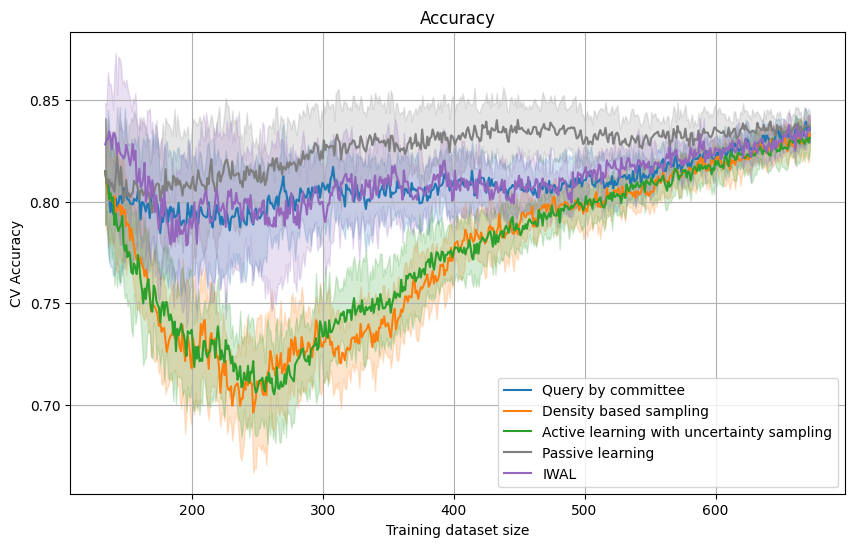

In [20]:
# Load the data
exe1 = pd.read_csv('./exe1_data.csv', header=0)

# Define the x-axis range
x_values = range(int(0.2 * len(X)), int(0.2 * len(X)) + len(exe1['train_mean']))

# Create the plot
plt.figure(figsize=(10, 6))

# Plot for Query by committee
plt.plot(x_values, exe1['train_mean'], label='Query by committee', color='#1f77b4')
plt.fill_between(x_values, exe1['train_mean'] - exe1['train_std'], exe1['train_mean'] + exe1['train_std'], color='#1f77b4', alpha=0.2)

# Plot for Density based sampling
plt.plot(x_values, exe1['train_mean_1'], label='Density based sampling', color='#ff7f0e')
plt.fill_between(x_values, exe1['train_mean_1'] - exe1['train_std_1'], exe1['train_mean_1'] + exe1['train_std_1'], color='#ff7f0e', alpha=0.2)

# Plot for Active learning with uncertainty sampling
plt.plot(x_values, exe1['train_mean_2'], label='Active learning with uncertainty sampling', color='#2ca02c')
plt.fill_between(x_values, exe1['train_mean_2'] - exe1['train_std_2'], exe1['train_mean_2'] + exe1['train_std_2'], color='#2ca02c', alpha=0.2)

# Plot for Passive learning
plt.plot(x_values, exe1['train_mean_3'], label='Passive learning', color='#7f7f7f')
plt.fill_between(x_values, exe1['train_mean_3'] - exe1['train_std_3'], exe1['train_mean_3'] + exe1['train_std_3'], color='#7f7f7f', alpha=0.2)

# Plot for IWAL 
plt.plot(x_values, train_mean_4, label='IWAL', color='#9467bd')
plt.fill_between(x_values, train_mean_4 - train_std_4, train_mean_4 + train_std_4, color='#9467bd', alpha=0.2)

# Add labels, title, and legend
plt.xlabel('Training dataset size')
plt.ylabel('CV Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# store the data
variables = [train_mean_4, train_std_4]
var_names = ['train_mean_4', 'train_std_4']
exe2_data = pd.DataFrame({name: var for name, var in zip(var_names, variables)})
exe2_data.to_csv("exe2_data.csv", index=False, header=True)